In [1]:
import re
import time
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
import lyricsgenius as lg
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

C:\Users\eoinp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('songs_lyrics.csv')
df.dropna(axis = 0, inplace = True)
df

,Artist,Title,Mood,lyrics
0,Usher,There Goes My Baby,relaxed,13 ContributorsThere Goes My Baby Lyrics\n\nYe...
1,Da'Ville,On My Mind,relaxed,1 ContributorOn My Mind LyricsAhhhhhhhh\nYou'r...
2,Rihanna,Rockstar 101,relaxed,"17 ContributorsROCKSTAR 101 Lyrics\nI told ya,..."
3,J. Holiday,Bed,relaxed,30 ContributorsBed Lyrics\n\nJ. Holiday\nOo-oh...
4,Morgan Heritage,Don't Haffi Dread,angry,"1 ContributorDon’t Haffi Dread LyricsYeah, yea..."
...,...,...,...,...
1995,David Bowie,I'm Afraid Of Americans,angry,38 ContributorsI’m Afraid of Americans Lyrics\...
1996,U2,The Refugee,angry,"6 ContributorsThe Refugee Lyrics\nWa-war, she'..."
1997,Lair Of The Minotaur,Evil Power,angry,1 ContributorEvil Power LyricsAt the dawn of v...
1998,Jimmy Ruffin,I've Passed This Way Before,angry,4 ContributorsI’ve Passed This Way Before Lyri...


In [ ]:
''' used only to get the lyrics for the songs
genius = lg.Genius(secret_id, skip_non_songs = True, remove_section_headers = True)

def lyrics_by_song(artist, title):
    succ = False
    while not succ:
        try:
            song = genius.search_song(title, artist)
            if not song:
                print("Could not find specified song.")
                return
            lyrics = song.lyrics
            succ = True
        except Exception as e:
            print(e)
            time.sleep(60)

        time.sleep(0.1)
        
    return lyrics

lyrics = []
for i in range(len(df)):
    lyrics.append(lyrics_by_song(df.loc[i]['Artist'], df.loc[i]['Title']))
    
df['lyrics'] = lyrics
df.to_csv('songs_lyrics.csv')

'''

In [3]:
# songs with erroneous lyrics
df.drop([136, 166], axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [4]:
# cleaning lyrics of extraneous information (ads for concert tickets, translations, etc.)
def text_process(text):
    text = re.sub(r'\d+[a-zA-Z 0-9]+Lyrics', '', text)
    text = re.sub('r[a-zA-Z ]+Lyrics', '', text)
    text = re.sub(r'See [\S $0-9]+ Live[a-zA-Z $0-9 ]+', '', text)
    text = re.sub(r'You might also like', '', text)
    text = re.sub(r'[0-9]+Embed', '', text)
    text = re.sub(r'Embed', '', text)
    text = re.sub(r'\d+ Contributors?', '', text)
    text = re.sub(r'Verse\d+', '', text)
    text = re.sub(r'Repeat c?C?horus', '', text)
    
    return text

In [5]:
# cleaning lyrics by removing punctuation, stopwords, and putting in lowercase
def word_process(text):
    accepted = list(string.ascii_letters)
    accepted.append(' ')
    
    text = [char for char in text if char in accepted]
    text = [char for char in text if char not in string.punctuation]
    text = ''.join(text)
    words = word_tokenize(text)
    words = [word.lower() for word in words if word not in stopwords.words('english')]
    words = ' '.join(words)
    
    return words

In [6]:
# wrapper function to perform above functions
def clean_data(data):
    for i in range(len(data)):
        song = data.loc[i]['lyrics']
        song = text_process(song)
        song = song.replace('\n', ' ')
        song = word_process(song)
        data.loc[i]['lyrics'] = song
    
    return data

In [7]:
# creating dictionary of all words used across lyrics - vocabulary
def word_counts(data):
    word_list = []
    for i in range(len(df_clean)):
        song = df.loc[i]['lyrics']
        words = word_tokenize(song)
        for word in words:
            if word != '' and word != 'nan':
                word_list.append(word)
            
    corpus = Counter(word_list)
    total_words = len(corpus)
    corpus_s = corpus.most_common(total_words)
    
    return corpus_s

In [8]:
# translating words in lyrics to integers using vocab2int dictionary
def encoding(data, vocab):
    encoded = []
    for i in range(len(data)):
        song = df.loc[i]['lyrics']
        song2int = [vocab[lyric] for lyric in song if lyric in vocab.keys()]
        encoded.append(song2int)
        
    return encoded

In [9]:
# padding or slicing lyrics depending on their length
def pad_seq(encoded, length):
    data = np.zeros((len(encoded), length), dtype = int)
    
    for i, song in enumerate(encoded):
        song_len = len(song)
        
        if song_len <= length:
            zeroes = list(np.zeros(length - song_len))
            padded = zeroes + song
            
        else:
            padded = song[:length]
            
        data[i, :] = np.array(padded)
        
    return data

In [10]:
df_clean = clean_data(df)
vocabulary = word_counts(df_clean)
vocabulary

[('i', 21769),
 ('love', 9367),
 ('im', 4857),
 ('and', 4357),
 ('you', 4068),
 ('the', 3846),
 ('dont', 3488),
 ('know', 3445),
 ('like', 3382),
 ('one', 2869),
 ('oh', 2615),
 ('baby', 2562),
 ('go', 2334),
 ('youre', 2281),
 ('got', 2177),
 ('get', 2084),
 ('time', 2062),
 ('see', 2021),
 ('never', 1845),
 ('come', 1829),
 ('but', 1825),
 ('na', 1812),
 ('way', 1799),
 ('home', 1799),
 ('cant', 1790),
 ('take', 1770),
 ('yeah', 1760),
 ('want', 1734),
 ('ill', 1649),
 ('say', 1613),
 ('fire', 1518),
 ('let', 1492),
 ('would', 1467),
 ('its', 1444),
 ('could', 1419),
 ('girl', 1415),
 ('said', 1365),
 ('que', 1365),
 ('he', 1339),
 ('de', 1337),
 ('us', 1323),
 ('back', 1316),
 ('so', 1313),
 ('says', 1312),
 ('life', 1298),
 ('little', 1272),
 ('good', 1266),
 ('away', 1242),
 ('day', 1241),
 ('heart', 1231),
 ('make', 1226),
 ('tell', 1220),
 ('man', 1177),
 ('a', 1171),
 ('we', 1157),
 ('god', 1157),
 ('well', 1127),
 ('need', 1126),
 ('thats', 1103),
 ('no', 1102),
 ('when', 1100

In [11]:
vocab2int = {w : i+1 for i, (w, c) in enumerate(vocabulary)}
vocab2int

{'i': 1,
 'love': 2,
 'im': 3,
 'and': 4,
 'you': 5,
 'the': 6,
 'dont': 7,
 'know': 8,
 'like': 9,
 'one': 10,
 'oh': 11,
 'baby': 12,
 'go': 13,
 'youre': 14,
 'got': 15,
 'get': 16,
 'time': 17,
 'see': 18,
 'never': 19,
 'come': 20,
 'but': 21,
 'na': 22,
 'way': 23,
 'home': 24,
 'cant': 25,
 'take': 26,
 'yeah': 27,
 'want': 28,
 'ill': 29,
 'say': 30,
 'fire': 31,
 'let': 32,
 'would': 33,
 'its': 34,
 'could': 35,
 'girl': 36,
 'said': 37,
 'que': 38,
 'he': 39,
 'de': 40,
 'us': 41,
 'back': 42,
 'so': 43,
 'says': 44,
 'life': 45,
 'little': 46,
 'good': 47,
 'away': 48,
 'day': 49,
 'heart': 50,
 'make': 51,
 'tell': 52,
 'man': 53,
 'a': 54,
 'we': 55,
 'god': 56,
 'well': 57,
 'need': 58,
 'thats': 59,
 'no': 60,
 'when': 61,
 'night': 62,
 'world': 63,
 'right': 64,
 'cause': 65,
 'feel': 66,
 'she': 67,
 'my': 68,
 'give': 69,
 'if': 70,
 'every': 71,
 'la': 72,
 'all': 73,
 'think': 74,
 'gon': 75,
 'it': 76,
 'theres': 77,
 'ive': 78,
 'people': 79,
 'always': 80,
 'in

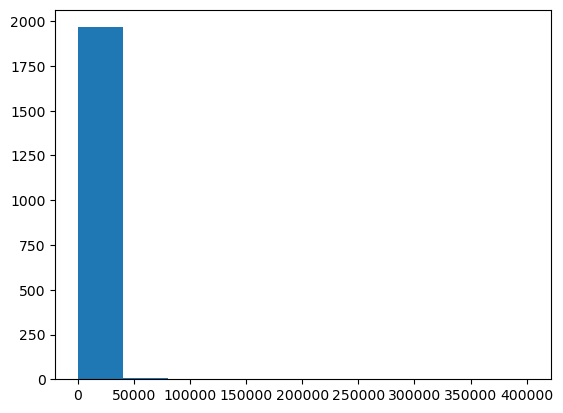

In [12]:
songs_int = encoding(df_clean, vocab2int)

songs_len = [len(s) for s in songs_int]
plt.hist(songs_len)
plt.show()

In [13]:
x_final = pad_seq(songs_int, 300)
x_final

array([[ 128, 1038,   54, ..., 1729,   54,  128],
       [   0,    0,    0, ..., 1024, 1515, 1038],
       [   1,  801,  705, ..., 3546,    1, 1191],
       ...,
       [  54,  801, 1729, ..., 1038, 1024,  128],
       [   1, 2111, 1038, ...,  801,    1, 1191],
       [1106,  705, 1199, ...,  946, 1038, 1106]])

In [14]:
le = LabelEncoder()
y_enc = le.fit_transform(df['Mood'])

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y_enc, test_size = 0.25, random_state = 424)

In [123]:
params = {'learning_rate' : 0.001,
          'train_batch_size' : 74,
          'test_batch_size' : 38,
          'epochs' : 10}

In [124]:
train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

trainloader = DataLoader(train, shuffle = True, batch_size = params['train_batch_size'])
testloader = DataLoader(test, shuffle = False, batch_size = params['test_batch_size'])

In [126]:
class RNN(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding(input_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first = True)
        self.fcl = nn.Linear(hidden_dim, 4)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embed(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.fcl(ht[-1])

In [127]:
# initializing network with parameters
v_size = len(vocab2int) + 1
emb_dim = 300
hidden_dim = 256
n_layers = 2

network = RNN(v_size, emb_dim, hidden_dim)
optimizer = torch.optim.Adam(network.parameters(), lr = params['learning_rate'])

In [129]:
# training loop
network.train()
for e in range(params['epochs']):    
    for x, y in trainloader:
        x = x.long()
        y = y.long()
        
        out = network(x)
        optimizer.zero_grad()
        
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        
        network.train()
        
    print('Epoch: {}/{}...'.format(e + 1, params['epochs']),
          'Loss: {:.6f}...'.format(loss.item()))

Epoch: 1/10... Loss: 1.377497...
Epoch: 2/10... Loss: 1.289656...
Epoch: 3/10... Loss: 1.409452...
Epoch: 4/10... Loss: 1.245178...
Epoch: 5/10... Loss: 1.003172...
Epoch: 6/10... Loss: 1.171110...
Epoch: 7/10... Loss: 1.126817...
Epoch: 8/10... Loss: 0.961008...
Epoch: 9/10... Loss: 0.983605...
Epoch: 10/10... Loss: 0.949893...


In [138]:
# evaluating the network
correct = 0
sum_loss = 0.0

network.eval()
for x, y in testloader:
    x = x.long()
    y = y.long()
    
    out = network(x)
    
    loss = F.cross_entropy(out, y)
    
    pred = torch.max(out, 1)[1]
    
    if pred == y:
        correct += 1
        
    sum_loss += loss.item()
    
avg_loss = sum_loss / params['epochs']
accuracy = correct / len(testloader.dataset)
    
print('Average test loss: {:.6f}'.format(avg_loss))
print('Test accuracy: {:.3f}%'.format(accuracy * 100))

Average test loss: 1.650482
Test accuracy: 41.296%


In [220]:
# inputting some songs from my favorite artists for sentiment analysis
more_lyrics = pd.read_csv('topsongs.csv', encoding = 'unicode_escape', engine = 'python')
more_lyrics

,lyrics,mood
0,Living well is not my kind of revenge\nYou sho...,0
1,"If I'm a bad person, you don't like me\nWell, ...",0
2,I'm in the business of misery\nLet's take it f...,0
3,I'm sitting in a room\nMade up of only big whi...,0
4,"I got a lot to say to you, yeah, I got a lot t...",0
5,"There I was again tonight\nForcing laughter, f...",1
6,When you think of all the late nights\nLame fi...,2
7,Draw the cat eye sharp enough to kill a man\nY...,0
8,"When the morning came, we\nWere cleaning incen...",3
9,"Cause, baby, now we got bad blood\nYou know it...",0


In [221]:
more_lyrics_clean = clean_data(more_lyrics)
lyrics_int = encoding(more_lyrics_clean, vocab2int)
x_pad = pad_seq(lyrics_int, 300)

C:\Users\eoinp\AppData\Local\Temp\ipykernel_196\1208719937.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[i]['lyrics'] = song


In [226]:
y_val = np.array(more_lyrics['mood'])
valdata = TensorDataset(torch.from_numpy(x_pad), torch.from_numpy(y_val))
val_loader = DataLoader(valdata, shuffle = False, batch_size = 1)

In [242]:
# comparing network output to my interpretations
preds = []
correct = 0

network.eval()
for x, y in val_loader:
    x = x.long()
    y = y.long()
    
    out = network(x)
    
    loss = F.cross_entropy(out, y)
    pred = torch.max(out, 1)[1]
    preds.append(pred)
    
    if pred == y:
        correct += 1
    
    sum_loss += loss.item()
    
avg_loss = sum_loss / params['epochs']
accuracy = correct / len(val_loader.dataset)  

print('Average loss: {:.6f}'.format(avg_loss))
print('Accuracy: {:.3f}%'.format(accuracy * 100))

Average loss: 13.768345
Accuracy: 40.000%
